# Problem description

[Simple problem description here]

# Section 1: Import packages

In [1]:
import gurobipy as gp
from gurobipy import GRB
import random
import math
import matplotlib.pyplot as plt
import time

# Section 2: Generate random bus stops

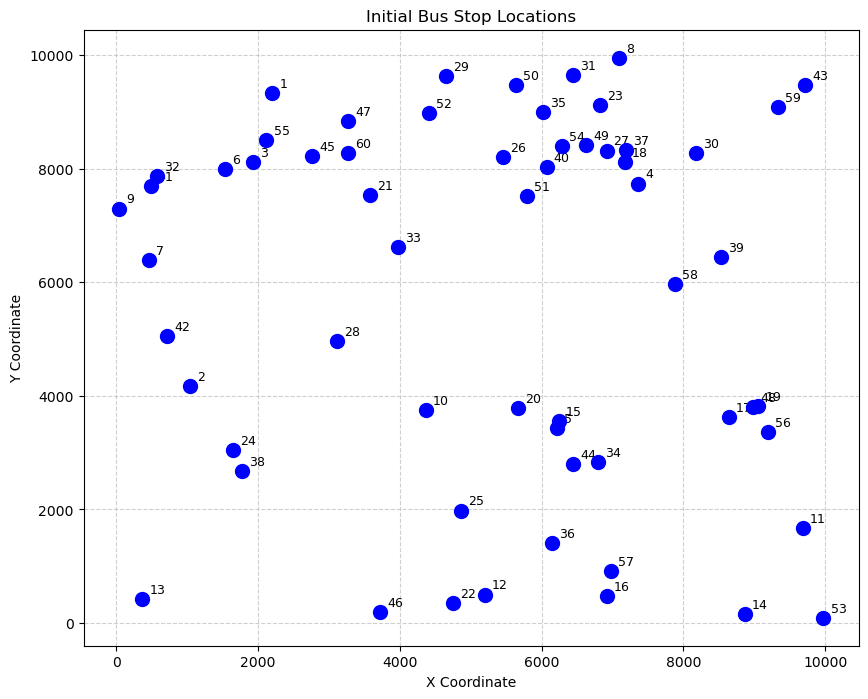

Excel file 'bus_stop_coordinates.xlsx' has been created.


In [2]:
# Small-scale Problem: (Q, n, time_limit) = (50, 3, 300)
'''
Q = 50   # Number of bus stops
n = 3  # Number of bus routes
'''
# Testing Problem: : (Q, n, time_limit) = (60, 3, 1200)
Q = 60   # Number of bus stops
n = 3  # Number of bus routes

time_limit = 3600 # Number of seconds before the algorithms stop
# (Q,n) = (30,5) takes Gurobi ~30 seconds, 46310.73 distance
# (Q,n) = (50,3) takes Gurobi ~300 seconds, 56385.88 distance

# Generate random coordinates for bus stops (0,0) to (10000,10000)
random.seed(1) # Reproducability
stops_coords = {i: (random.randint(0, 10000), random.randint(0, 10000)) for i in range(1, Q + 1)}

# Calculate Euclidean distances
distances = {}
for i in range(1, Q + 1):
    for j in range(1, Q + 1):
        if i != j:
            x1, y1 = stops_coords[i]
            x2, y2 = stops_coords[j]
            distances[(i, j)] = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Plot 1: Initial bus stop locations
plt.figure(figsize=(10, 8))
for i in range(1, Q + 1):
    plt.scatter(stops_coords[i][0], stops_coords[i][1], color='blue', s=100, zorder=5)
    plt.text(stops_coords[i][0] + 100, stops_coords[i][1] + 100, str(i), fontsize=9)
plt.title('Initial Bus Stop Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

import pandas as pd

# Convert stops_coords to a DataFrame
stops_df = pd.DataFrame.from_dict(stops_coords, orient='index', columns=['X', 'Y'])
stops_df.index.name = 'StopID'

# Export to Excel
stops_df.to_excel('bus_stop_coordinates.xlsx', index=True)

print("Excel file 'bus_stop_coordinates.xlsx' has been created.")


# Section 3: Exact optimisation method (Gurobi)

## Gurobi model set-up

In [3]:
baseline = count = 0
for key,val in distances.items():
    #print(val)
    baseline+= val
    count+= 1
    if count ==5:
        break
print(baseline)

20531.379379739006


In [ ]:
model = gp.Model("BusRouteAssignmentTSP")
model.setParam('Seed', 1)

# Decision variables
x = model.addVars(Q, n, vtype=GRB.BINARY, name="assign") # x[i, k] = 1 if bus stop i is assigned to route k, 0 otherwise.
y = model.addVars(Q, Q, n, vtype=GRB.BINARY, name="route_edge") # y[i,j,k] = 1 if route k includes a directed edge from stop i to stop j, 0 otherwise.

# Objective function: Minimise the total travel distance of all routes.
model.setObjective(gp.quicksum(distances[(i+1,j+1)] * y[i,j,k]
for i in range(Q) for j in range(Q) if i != j for k in range(n)), GRB.MINIMIZE)

# Constraints
# 1. Each bus stop assigned to exactly one route
for i in range(Q):
    model.addConstr(gp.quicksum(x[i,k] for k in range(n)) == 1, name=f"assign_one_route_stop_{i+1}")
# 2. Degree Constraints: If a stop i is assigned to route k, then it must have exactly one incoming and one outgoing edge in that route:
for k in range(n):
    for i in range(Q):
        model.addConstr(gp.quicksum(y[j,i,k] for j in range(Q) if j != i) == x[i,k], name=f"in_degree_stop_{i+1}_route_{k+1}")
        model.addConstr(gp.quicksum(y[i,j,k] for j in range(Q) if j != i) == x[i,k], name=f"out_degree_stop_{i+1}_route_{k+1}")

    route_k_is_used = model.addVars(n, vtype=GRB.BINARY, name="route_k_is_used") # = 1 if route k is used (i.e., has assigned stops), 0 otherwise

    # 3. Force all routes to be used: This enforces that each route must be marked as "used" (route_k_is_used = 1)
    model.addConstr(gp.quicksum(route_k_is_used[k] for k in range(n)) == n, name="force_all_routes_used")

    for k in range(n):
        # 4. Minimum number of stops per used route: If route k is used, it must serve at least 3 stops.
        model.addConstr(gp.quicksum(x[i,k] for i in range(Q)) >= 3 * route_k_is_used[k], name=f"min_stops_if_used_{k+1}")
        # 5. Maximum number of stops per route: If route k is not used, no stops can be assigned. If used, it can serve up to Q stops.
        model.addConstr(gp.quicksum(x[i,k] for i in range(Q)) <= Q * route_k_is_used[k], name=f"max_stops_if_used_{k+1}")
        # 6. Edge count equals number of assigned stops: The number of directed edges used in route k must match the number of stops assigned to it (forming a TSP loop):
        model.addConstr(
        gp.quicksum(y[i,j,k] for i in range(Q) for j in range(Q) if i != j) 
        == gp.quicksum(x[i,k] for i in range(Q)), 
        name=f"max_edges_if_used_{k+1}")

        # 7. Minimum route distance
        model.addConstr(
            gp.quicksum(distances[(i+1,j+1)] * y[i,j,k] for i in range(Q) for j in range(Q) if i != j) >= 8000)

Set parameter Username
Set parameter LicenseID to value 2669527
Academic license - for non-commercial use only - expires 2026-05-22
Set parameter Seed to value 1


'\nEntire portion underneath should be redundant now, and can be deleted in future before submission.\n\n        # Ensure that if route_k_is_used[k] is 0, sum(y) must be 0\n        #model.addConstr(gp.quicksum(y[i,j,k] for i in range(Q) for j in range(Q) if i != j) <= Q * Q * route_k_is_used[k], name=f"no_edges_if_not_used_{k+1}")\n        \n        model.addConstr(\n        gp.quicksum(y[i,j,k] for i in range(Q) for j in range(Q) if i != j) \n        <= gp.quicksum(x[i,k] for i in range(Q)), \n        name=f"max_edges_if_used_{k+1}"\n        )\n\n    # And for this problem, all n routes should be used (or we want to minimize all distances).\n    # If a route is used, it must have >= 3 stops.\n    # If you want ALL n routes to *eventually* form TSP tours:\n    # model.addConstr(gp.quicksum(route_k_is_used[k] for k in range(n)) == n, name="all_routes_must_be_used")\n'

## Define subtour elimination function (Not MTZ)

In [5]:
# --- Iterative Subtour Elimination (using a callback) ---

# Helper function to find subtours in a given edge set (used in Gurobi callbacks)
def find_subtours(edges, n_nodes):
    visited = [False] * n_nodes
    paths = [[] for _ in range(n_nodes)]

    # Build adjacency list for each node
    adj = [[] for _ in range(n_nodes)]
    for i, j in edges:
        adj[i].append(j)
        paths[i].append(j)

    tour = []
    stack = []

    # Loop over all nodes to detect connected components (potential subtours)
    for start_node in range(n_nodes):
        if not visited[start_node]:
            current_path = []
            stack.append(start_node)
            visited[start_node] = True

            # Depth-first search (DFS) to find all nodes reachable from start_node
            while stack:
                u = stack.pop()
                current_path.append(u)
                for v in adj[u]:
                    if not visited[v]:
                        visited[v] = True
                        stack.append(v)

            # Add the component (cycle or not) to the list of tours
            tour.append(current_path)

    # Further process the components to detect actual subtours (cycles)
    # This section assumes we are given a feasible integer solution
    # and tries to return a true subtour with length < n_nodes

    unvisited_nodes = list(range(n_nodes))
    while unvisited_nodes:
        node = unvisited_nodes.pop(0)

        # Skip isolated nodes with no outgoing edges
        if not adj[node]:
            continue

        # Traverse the cycle starting from this node
        cycle = [node]
        current = adj[node][0]  # Follow the first outgoing edge

        while current != node:
            if current in cycle:  # Should not happen in a valid TSP solution
                break
            cycle.append(current)
            if not adj[current]:  # Dead end reached, not a cycle
                cycle = []
                break
            current = adj[current][0]

        # Return the first non-trivial subtour found
        if len(cycle) < n_nodes and len(cycle) > 1:
            return cycle


## Define callback function

In [6]:
# --- Consolidated Master Callback Function ---
def master_callback(model, where):
    # 1. Track bounds during optimization (used for plotting convergence)
    if where == GRB.Callback.MIP:
        current_runtime = model.cbGet(GRB.Callback.RUNTIME)
        current_objbst = model.cbGet(GRB.Callback.MIP_OBJBST)  # Best known feasible objective value (upper bound)
        current_objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)  # Best known bound on the optimal value (lower bound)

        # Record runtime and bounds for visualization
        if current_runtime is not None:
            time_points.append(current_runtime)
            
            # If upper bound exists, append it; otherwise, repeat last or use large default
            if current_objbst < GRB.INFINITY:
                upper_bounds.append(current_objbst)
            else:
                upper_bounds.append(upper_bounds[-1] if upper_bounds else 1e10)
            
            # If lower bound exists, append it; otherwise, repeat last or use zero
            if current_objbnd > -GRB.INFINITY:
                lower_bounds.append(current_objbnd)
            else:
                lower_bounds.append(lower_bounds[-1] if lower_bounds else 0)

    # 2. Add subtour elimination constraints during the branch-and-bound process
    if where == GRB.Callback.MIPNODE:
        if model.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
            current_x_vals = model.cbGetNodeRel(x)  # Get current fractional solution of x at node
            current_y_vals = model.cbGetNodeRel(y)  # Get current fractional solution of y at node

            for k in range(n):
                # Identify which stops are (fractionally) assigned to route k
                assigned_stops_0_indexed = [i for i in range(Q) if current_x_vals[i,k] > 0.5]
                if len(assigned_stops_0_indexed) >= 3:
                    edges_in_route = []

                    # Map original indices to a compact range for subtour detection
                    node_map = {original_idx: new_idx for new_idx, original_idx in enumerate(assigned_stops_0_indexed)}
                    
                    # Extract edges between assigned stops that are (fractionally) used
                    for i_orig in assigned_stops_0_indexed:
                        for j_orig in assigned_stops_0_indexed:
                            if i_orig != j_orig and current_y_vals[i_orig, j_orig, k] > 0.5:
                                edges_in_route.append((node_map[i_orig], node_map[j_orig]))
                    
                    # Check for subtours (i.e., disconnected cycles that are too small)
                    subtour = find_subtours(edges_in_route, len(assigned_stops_0_indexed))
                    if subtour:
                        # Map back to original indices and add a cut to eliminate this subtour
                        original_subtour_nodes = [assigned_stops_0_indexed[node_map_idx] for node_map_idx in subtour]
                        model.cbCut(gp.quicksum(
                            y[i_node, j_node, k]
                            for i_node in original_subtour_nodes
                            for j_node in original_subtour_nodes
                            if i_node != j_node
                        ) <= len(original_subtour_nodes) - 1)
                        return  # Add only one cut per callback call

    # 3. Add subtour elimination constraints for integer feasible solutions
    elif where == GRB.Callback.MIPSOL:
        current_x_vals = model.cbGetSolution(x)  # Get integer solution of x
        current_y_vals = model.cbGetSolution(y)  # Get integer solution of y

        for k in range(n):
            # Identify which stops are assigned to route k
            assigned_stops_0_indexed = [i for i in range(Q) if current_x_vals[i,k] > 0.5]
            if len(assigned_stops_0_indexed) >= 3:
                edges_in_route = []

                # Map original indices to a compact index space for subtour detection
                node_map = {original_idx: new_idx for new_idx, original_idx in enumerate(assigned_stops_0_indexed)}
                
                # Extract directed edges from solution
                for i_orig in assigned_stops_0_indexed:
                    for j_orig in assigned_stops_0_indexed:
                        if i_orig != j_orig and current_y_vals[i_orig, j_orig, k] > 0.5:
                            edges_in_route.append((node_map[i_orig], node_map[j_orig]))
                
                # Check for subtours and eliminate if found
                subtour = find_subtours(edges_in_route, len(assigned_stops_0_indexed))
                if subtour:
                    original_subtour_nodes = [assigned_stops_0_indexed[node_map_idx] for node_map_idx in subtour]
                    model.cbLazy(gp.quicksum(
                        y[i_node, j_node, k]
                        for i_node in original_subtour_nodes
                        for j_node in original_subtour_nodes
                        if i_node != j_node
                    ) <= len(original_subtour_nodes) - 1)
                    return  # Only one lazy constraint per callback


## Solve with Gurobi

In [7]:
# --- Configure and Optimize the model ---
# Set general Gurobi parameters
model.Params.LogToConsole = 1 # Enable logging to console
model.Params.TimeLimit = time_limit # Set a time limit (e.g., 1800 seconds = 30 minutes)
model.Params.LazyConstraints = 1 # CRUCIAL: Enable lazy constraints for callback

# Lists to record bounds over time for plotting (initialized BEFORE the optimize call)
time_points = []
upper_bounds = []
lower_bounds = []

# --- Optimize the model (only ONE call) ---
print("\nStarting Gurobi Optimization...")
model.optimize(master_callback) # Pass the single, consolidated callback function
print("Gurobi Optimization Finished.")

Set parameter LogToConsole to value 1
Set parameter TimeLimit to value 3600
Set parameter LazyConstraints to value 1

Starting Gurobi Optimization...
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Xeon(R) W-10885M CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  3600
Seed  1
LazyConstraints  1

Optimize a model with 459 rows, 10989 columns and 87147 nonzeros
Model fingerprint: 0x5dcb41c1
Variable types: 0 continuous, 10989 integer (10989 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [8e+01, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+03]
Presolve removed 93 rows and 69 columns
Presolve time: 0.10s
Presolved: 366 rows, 10920 columns, 32580 nonzeros
Variable types: 0 continuous, 10920 integer (10920 binary)

Root relaxation: objective 4.707887e+04, 793 itera

## Print Gurobi solution


Feasible solution saved to 'Experiment_solution.sol'

Bus Route 1 assigned stops: [1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 24, 25, 26, 29, 32, 35, 36, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60]
  Tour for Route 1: 1 -> 45 -> 60 -> 47 -> 52 -> 29 -> 50 -> 35 -> 26 -> 51 -> 40 -> 54 -> 49 -> 18 -> 4 -> 39 -> 58 -> 15 -> 5 -> 17 -> 48 -> 19 -> 56 -> 11 -> 53 -> 14 -> 16 -> 57 -> 36 -> 25 -> 12 -> 22 -> 46 -> 13 -> 38 -> 24 -> 2 -> 42 -> 7 -> 9 -> 41 -> 32 -> 6 -> 3 -> 55 -> 1
  Distance for Route 1: 45592.42

Bus Route 2 assigned stops: [10, 20, 21, 28, 33, 34, 44]
  Tour for Route 2: 10 -> 44 -> 34 -> 20 -> 33 -> 21 -> 28 -> 10
  Distance for Route 2: 12753.85

Bus Route 3 assigned stops: [8, 23, 27, 30, 31, 37, 43, 59]
  Tour for Route 3: 8 -> 31 -> 23 -> 27 -> 37 -> 30 -> 59 -> 43 -> 8
  Distance for Route 3: 8061.32


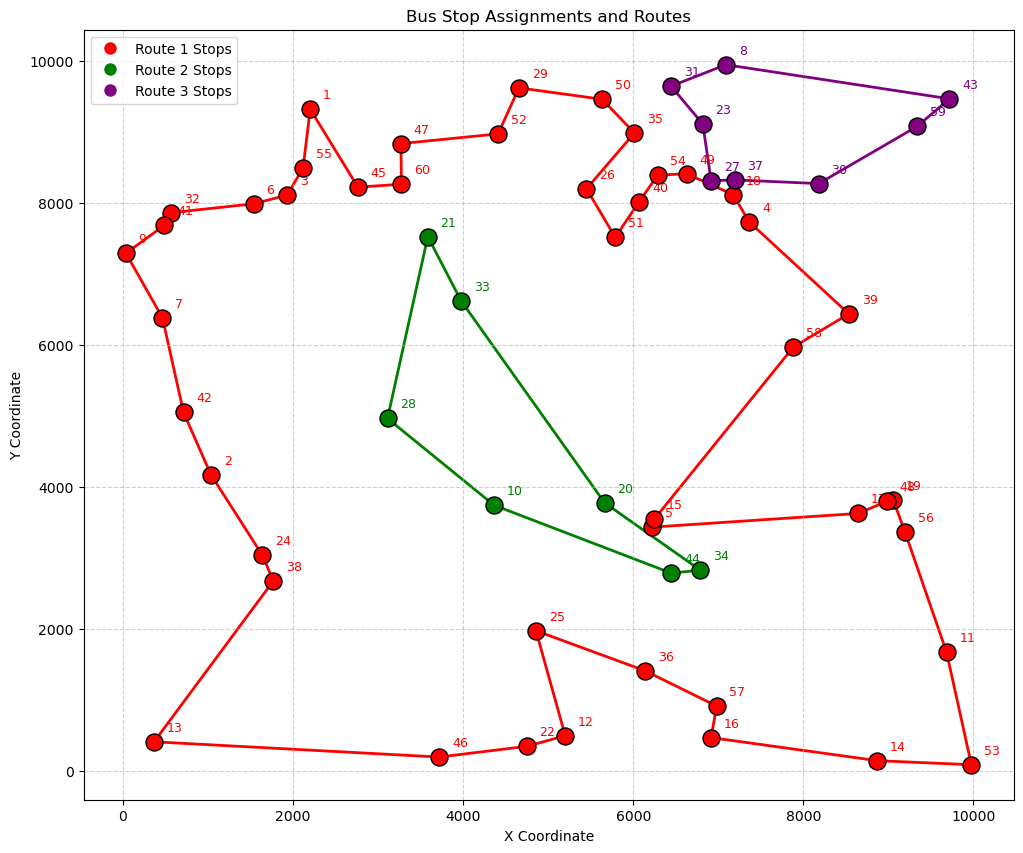

In [11]:
# --- Print Results ---
if model.SolCount > 0:
    model.write("Experiment_solution.sol")  # Save current best feasible solution
    print("\nFeasible solution saved to 'Experiment_solution.sol'")

    # Dictionary to store stops assigned to each route
    routes_assigned_stops = {k: [] for k in range(n)}
    for i in range(Q):  # Iterate over 0-indexed bus stops
        for k_idx in range(n):
            if x[i,k_idx].x > 0.5:
                routes_assigned_stops[k_idx].append(i + 1)  # Convert to 1-indexed for readability

    # --- Plot: Bus Stop Locations with Route Assignments and Tours ---
    plt.figure(figsize=(12, 10))
    colors = ['red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'lime']
    
    for k_idx in range(n):  # Loop through each bus route
        assigned_stops_for_route_k = routes_assigned_stops[k_idx]
        route_color = colors[k_idx % len(colors)]
        
        # Plot each assigned stop as a colored point with a label
        for stop_id in assigned_stops_for_route_k:
            plt.scatter(stops_coords[stop_id][0], stops_coords[stop_id][1], color=route_color, s=150, zorder=5, edgecolors='black')
            plt.text(stops_coords[stop_id][0] + 150, stops_coords[stop_id][1] + 150, str(stop_id), fontsize=9, color=route_color)

        # Only reconstruct and plot TSP tour if route is active and has ≥ 3 stops
        if len(assigned_stops_for_route_k) >= 3 and route_k_is_used[k_idx].x > 0.5:
            
            # Extract all active edges for this route from y variables
            actual_active_edges_for_route = []
            for i_node in assigned_stops_for_route_k:
                for j_node in assigned_stops_for_route_k:
                    if i_node != j_node and y[i_node-1, j_node-1, k_idx].x > 0.5:
                        actual_active_edges_for_route.append((i_node, j_node))
            
            # Reconstruct the tour from the directed edges
            reconstructed_path = []
            if actual_active_edges_for_route:
                start_node_in_path = actual_active_edges_for_route[0][0]  # Start from any edge's source
                current_node = start_node_in_path

                # Build a simple adjacency list to trace the path
                adj_list = {node: None for node in assigned_stops_for_route_k}
                for u, v in actual_active_edges_for_route:
                    adj_list[u] = v

                # Traverse the path until a loop is completed or fails
                while True:
                    reconstructed_path.append(current_node)
                    next_node = adj_list[current_node]
                    
                    if next_node == start_node_in_path:
                        reconstructed_path.append(next_node)  # Close the cycle
                        break
                    
                    current_node = next_node
                    
                    # Prevent infinite loop if cycle reconstruction fails
                    if len(reconstructed_path) > len(assigned_stops_for_route_k):
                        print(f"  Warning: Reconstruction exceeded node count for Route {k_idx+1}. Path: {reconstructed_path}")
                        break
            
            # --- Plot reconstructed path and print route summary ---
            if reconstructed_path and reconstructed_path[0] == reconstructed_path[-1] and len(reconstructed_path) == len(assigned_stops_for_route_k) + 1:
                for idx in range(len(reconstructed_path) - 1):
                    start_node_plot = reconstructed_path[idx]
                    end_node_plot = reconstructed_path[idx+1]
                    p1 = stops_coords[start_node_plot]
                    p2 = stops_coords[end_node_plot]
                    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=route_color, linewidth=2, linestyle='-', zorder=1)
                
                tour_distance = sum(distances[(reconstructed_path[i], reconstructed_path[i+1])] for i in range(len(reconstructed_path)-1))
                print(f"\nBus Route {k_idx+1} assigned stops: {assigned_stops_for_route_k}")
                print(f"  Tour for Route {k_idx+1}: {' -> '.join(map(str, reconstructed_path))}")
                print(f"  Distance for Route {k_idx+1}: {tour_distance:.2f}")
            else:
                # If reconstruction fails, fallback to edge-based distance
                print(f"\nBus Route {k_idx+1} assigned stops: {assigned_stops_for_route_k}")
                print(f"  Warning: Could not perfectly reconstruct full tour path for Route {k_idx+1}.")
                tour_distance = sum(distances[(i,j)] for i,j in actual_active_edges_for_route)
                print(f"  Calculated Distance from edges for Route {k_idx+1}: {tour_distance:.2f}")

        else:
            # Route not used or too few stops to form a tour
            print(f"\nBus Route {k_idx+1} assigned stops: {assigned_stops_for_route_k}")
            print(f"  Route {k_idx+1} has {len(assigned_stops_for_route_k)} stops and thus no standard TSP tour is formed (distance 0).")

    # Final plot settings
    plt.title('Bus Stop Assignments and Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    # Custom legend showing route colors
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Route {i+1} Stops',
                              markerfacecolor=colors[i % len(colors)], markersize=10) for i in range(n)]
    plt.legend(handles=legend_elements, loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# --- Handle other model statuses ---
elif model.status == GRB.INFEASIBLE:
    print("Model is infeasible.")
    print("Computing IIS...")
    model.computeIIS()
    model.write("infeasible_model.ilp")  # Write irreducible infeasible set (IIS) to file
    print("IIS written to 'infeasible_model.ilp'")

elif model.status == GRB.UNBOUNDED:
    print("Model is unbounded.")
else:
    print(f"Optimization ended with status {model.status}")


## Plot solution bounds over time

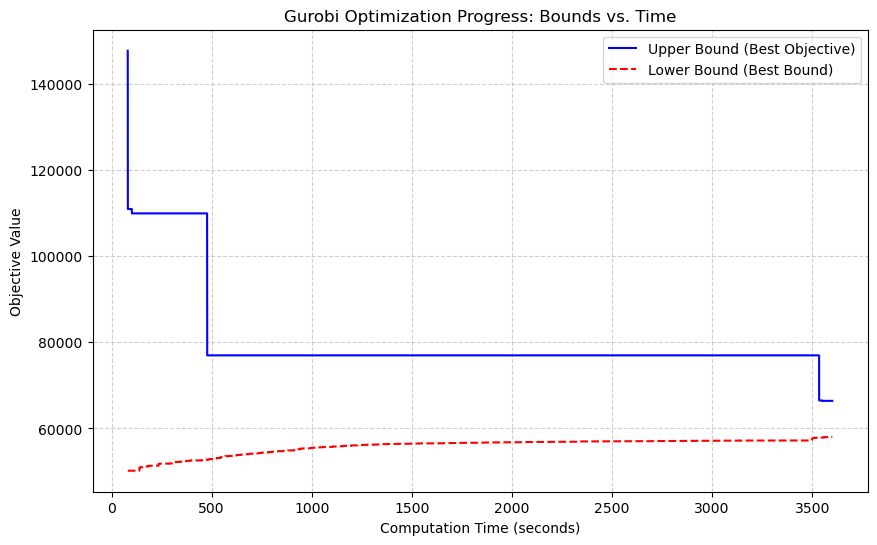

In [9]:
# --- Plot 3: Upper and Lower Bound values over Computation Time ---

# Initialize lists to store filtered data for plotting
gurobi_time_points = []
gurobi_upper_bounds = []
gurobi_lower_bounds = []

# Ensure time and bounds lists are available and of equal length
if time_points and upper_bounds and lower_bounds:
    for i in range(len(time_points)):
        # Filter out placeholder values (1e10 for upper, 0 for lower) from early iterations
        # Use a small epsilon margin to avoid floating-point edge cases
        if upper_bounds[i] < 0.99 * 1e10 and lower_bounds[i] > 0.01 * 0:
            gurobi_time_points.append(time_points[i])
            gurobi_upper_bounds.append(upper_bounds[i])
            gurobi_lower_bounds.append(lower_bounds[i])

# Plot only if we have more than one valid data point
if gurobi_time_points and len(gurobi_time_points) > 1:
    plt.figure(figsize=(10, 6))

    # Plot upper and lower bound trajectories over time
    plt.plot(gurobi_time_points, gurobi_upper_bounds, label='Upper Bound (Best Objective)', color='blue')
    plt.plot(gurobi_time_points, gurobi_lower_bounds, label='Lower Bound (Best Bound)', color='red', linestyle='--')

    plt.title('Gurobi Optimization Progress: Bounds vs. Time')
    plt.xlabel('Computation Time (seconds)')
    plt.ylabel('Objective Value')
    plt.legend()

    # Enhance readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Optional: Uncomment to apply log scale if time or values vary widely
    # plt.xscale('log')
    # plt.yscale('log')

    plt.show()
else:
    print("\nNo sufficient valid callback data recorded for plotting bounds (or only one data point).")


# Section 4: Metaheuristics method (Genetic Algorithm with Nearest Neighbour heuristics)


--- Starting Genetic Algorithm Optimization ---
Generating initial population...
  Generated individual 1/100
  Generated individual 2/100
  Generated individual 3/100
  Generated individual 4/100
  Generated individual 5/100
  Generated individual 6/100
  Generated individual 7/100
  Generated individual 8/100
  Generated individual 9/100
  Generated individual 10/100
  Generated individual 11/100
  Generated individual 12/100
  Generated individual 13/100
  Generated individual 14/100
  Generated individual 15/100
  Generated individual 16/100
  Generated individual 17/100
  Generated individual 18/100
  Generated individual 19/100
  Generated individual 20/100
  Generated individual 21/100
  Generated individual 22/100
  Generated individual 23/100
  Generated individual 24/100
  Generated individual 25/100
  Generated individual 26/100
  Generated individual 27/100
  Generated individual 28/100
  Generated individual 29/100
  Generated individual 30/100
  Generated individual 31/1

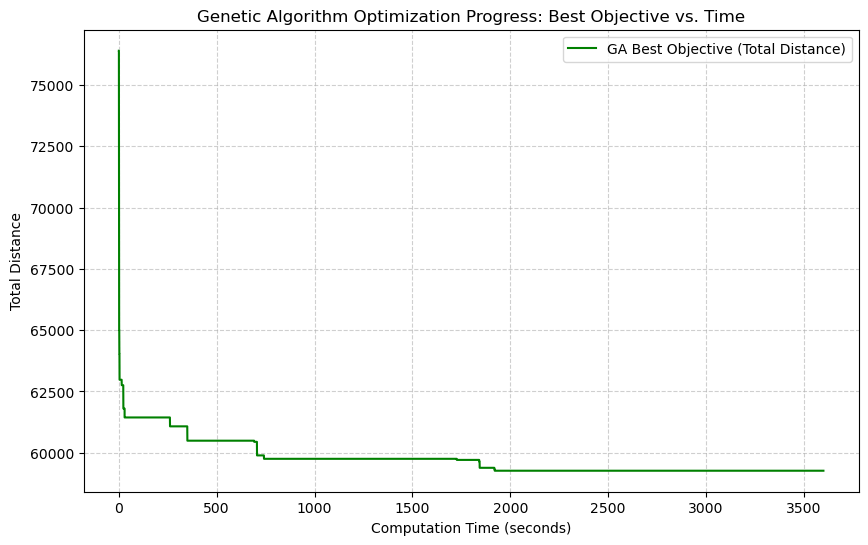

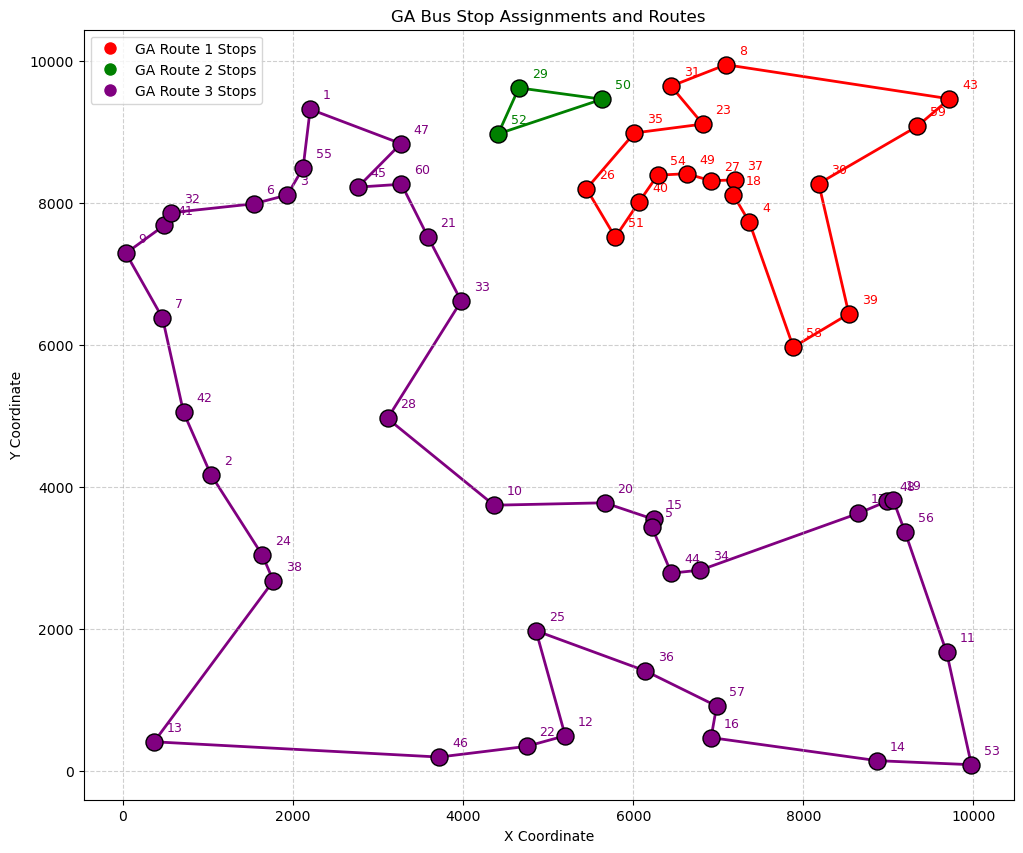

In [12]:
# Genetic Algorithm Implementation

# --- GA Parameters ---
POPULATION_SIZE = 100 # Changed from 20 to 100
TOURNAMENT_SIZE = max(2, Q // n)
MUTATION_RATE_ORDER = 0.3
MUTATION_RATE_PARTITION = 0.3

# --- Helper Functions for GA ---

def calculate_distance(stop1_id, stop2_id):
    """Calculates Euclidean distance between two stops (1-indexed IDs)."""
    return distances[(stop1_id, stop2_id)]

def nearest_neighbor_tour(start_node_id, available_stops):
    """
    Generates a tour using the Nearest Neighbor heuristic starting from a given node.
    Returns a list of 1-indexed stop IDs forming the tour.
    """
    tour = [start_node_id]
    current_node = start_node_id
    remaining_stops = set(available_stops) - {start_node_id}

    while remaining_stops:
        next_node = None
        min_dist = float('inf')
        
        for neighbor in remaining_stops:
            dist = calculate_distance(current_node, neighbor)
            if dist < min_dist:
                min_dist = dist
                next_node = neighbor
        
        tour.append(next_node)
        current_node = next_node
        remaining_stops.remove(next_node)
    
    return tour

def generate_initial_bus_stop_order_nn(all_bus_stop_ids):
    """
    Generates the overall_bus_stop_order using a single Nearest Neighbor tour
    of all bus stops.
    """
    # Start NN from a random stop among all available stops
    start_node = random.choice(all_bus_stop_ids)
    return nearest_neighbor_tour(start_node, all_bus_stop_ids)

def generate_initial_partition_size_list_evenly_distributed(Q, n):
    """
    Generates an initial partition_size_list with fixed, evenly distributed stops.
    """
    base_stops_per_route = Q // n
    remainder = Q % n
    
    partition = []
    for k_idx in range(n):
        if k_idx < remainder:
            partition.append(base_stops_per_route + 1)
        else:
            partition.append(base_stops_per_route)
    return partition

def calculate_total_distance(chromosome):
    """
    Calculates the total distance of all bus routes for a given chromosome.
    The overall_bus_stop_order is split into n route segments based on the partition_size_list.
    For each route segment, the total Euclidean distance is calculated by summing
    the distances between consecutive stops in that segment, and then adding
    the distance from the last stop back to the first stop (to close the tour loop).
    This calculation is a direct summation on the given order.
    """
    overall_bus_stop_order = chromosome[0]
    partition_size_list = chromosome[1]

    total_distance = 0.0
    current_idx = 0
    
    for route_k_size in partition_size_list:
        if route_k_size > 0:
            route_segment_stops = overall_bus_stop_order[current_idx : current_idx + route_k_size]
            current_idx += route_k_size

            if len(route_segment_stops) < 3:
                # Assign a very high penalty to avoid routes with less than 3 stops,
                # as the problem implies routes should form TSP tours and GA design states minimum 3 stops.
                total_distance += 1e10 # Large penalty
                continue

            # Sum distances for segments
            for i in range(route_k_size - 1):
                total_distance += calculate_distance(route_segment_stops[i], route_segment_stops[i+1])
            # Add distance from last stop back to first stop (to close the tour loop)
            total_distance += calculate_distance(route_segment_stops[-1], route_segment_stops[0])
            
    return total_distance

def fitness_function(chromosome):
    """
    The fitness value of a solution will be the inverse of the total distance of all bus routes.
    (Lower total distance = higher fitness).
    """
    total_dist = calculate_total_distance(chromosome)
    if total_dist == 0:
        return float('inf')
    return 1.0 / total_dist

def create_individual():
    """
    Creates a new individual (chromosome) for the population.
    overall_bus_stop_order: generated using Nearest Neighbor heuristic.
    partition_size_list: generated with fixed, evenly distributed stops.
    """
    all_stops_1_indexed = list(range(1, Q + 1))
    overall_bus_stop_order = generate_initial_bus_stop_order_nn(all_stops_1_indexed)
    partition_size_list = generate_initial_partition_size_list_evenly_distributed(Q, n)
    return [overall_bus_stop_order, partition_size_list]

def tournament_selection(population, fitnesses, tournament_size):
    """
    Selects parent individuals using Tournament Selection.
    """
    selected_parents = []
    for _ in range(2): # Select two parents
        tournament_contenders = random.sample(population, tournament_size)
        
        best_contender = None
        best_fitness = -float('inf')
        for contender in tournament_contenders:
            contender_fitness = fitnesses[tuple(map(tuple, contender))]
            if contender_fitness > best_fitness:
                best_fitness = contender_fitness
                best_contender = contender
        selected_parents.append(best_contender)
    return selected_parents[0], selected_parents[1]

def order_crossover(parent1_order, parent2_order):
    """
    Applies Order Crossover (OX) to the overall_bus_stop_order.
    """
    size = len(parent1_order)
    a, b = sorted(random.sample(range(size), 2))
    
    child_order = [None] * size
    child_order[a:b+1] = parent1_order[a:b+1]
    
    current_parent2_pos = b + 1
    if current_parent2_pos >= size:
        current_parent2_pos = 0

    for gene_p2 in parent2_order:
        if gene_p2 not in child_order:
            child_order[current_parent2_pos] = gene_p2
            current_parent2_pos += 1
            if current_parent2_pos >= size:
                current_parent2_pos = 0
                
    return child_order

def repair_partition_list(partition_list_raw, Q_total, n_routes, min_stops=3):
    """
    Repairs a partition_list to ensure:
    1. Sum of stops equals Q_total.
    2. No route has less than min_stops (default 3).
    3. No route exceeds maximum possible stops (Q_total - (n_routes - 1) * min_stops).
    """
    repaired_list = list(partition_list_raw) # Start with a copy
    
    # Step 1: Enforce minimum stops and calculate initial deviation
    current_sum = sum(repaired_list)
    
    # First pass: Ensure minimum stops per route, adjust sum
    for i in range(n_routes):
        if repaired_list[i] < min_stops:
            repaired_list[i] = min_stops
    
    # Calculate sum after enforcing minimums
    current_sum = sum(repaired_list)

    # Calculate max possible size for any one route (to prevent adding too much)
    max_size_for_one_route = Q_total - (n_routes - 1) * min_stops

    # Step 2: Adjust sum to Q_total by adding/removing from valid routes
    deviation = Q_total - current_sum

    if deviation != 0:
        # Get indices of routes that can be adjusted
        adjustable_indices = []
        if deviation > 0: # Need to add stops
            adjustable_indices = [i for i, size in enumerate(repaired_list) if size < max_size_for_one_route]
        else: # Need to remove stops
            adjustable_indices = [i for i, size in enumerate(repaired_list) if size > min_stops]

        # Distribute deviation
        while deviation != 0 and adjustable_indices:
            idx = random.choice(adjustable_indices)
            
            if deviation > 0: # Need to add
                if repaired_list[idx] < max_size_for_one_route:
                    repaired_list[idx] += 1
                    deviation -= 1
            else: # Need to remove
                if repaired_list[idx] > min_stops:
                    repaired_list[idx] -= 1
                    deviation += 1
            
            # Re-check adjustable indices as sizes might have changed
            if deviation > 0:
                adjustable_indices = [i for i, size in enumerate(repaired_list) if size < max_size_for_one_route]
            else:
                adjustable_indices = [i for i, size in enumerate(repaired_list) if size > min_stops]
                
            # Fallback if no adjustable indices (e.g., all routes are at min_stops or max_size)
            if not adjustable_indices and deviation != 0:
                # This state implies an unresolvable partition given constraints.
                # In a real GA, you might assign a high penalty or re-create this individual.
                # For this problem, it's very unlikely with Q=30, n=5, min_stops=3.
                # But if it happens, we break to avoid infinite loop.
                # If sum is still off, might need to relax min_stops temporarily or try again.
                break 

    # Final check for sum (should be Q_total if repair successful)
    if sum(repaired_list) != Q_total:
        # This can happen if constraints are too tight (e.g., cannot satisfy sum with min_stops=3).
        # Fallback: distribute remaining stops as evenly as possible without strict min_stops
        # This means some routes might temporarily drop below min_stops, which fitness func will penalize.
        remaining_deviation = Q_total - sum(repaired_list)
        if remaining_deviation != 0:
             # Just try to distribute or remove without strict min_stops for now
            for _ in range(abs(remaining_deviation)):
                idx_to_adjust = random.randint(0, n_routes - 1)
                if remaining_deviation > 0:
                    repaired_list[idx_to_adjust] += 1
                else:
                    repaired_list[idx_to_adjust] -= 1 # Can go below 3, fitness func handles penalty
        
    return repaired_list


def crossover(parent1, parent2):
    """
    Applies crossover to produce a child.
    For overall_bus_stop_order: Order Crossover (OX).
    For partition_size_list: Blending/Arithmetic Crossover with repair.
    """
    # Crossover overall_bus_stop_order using OX
    child_overall_bus_stop_order = order_crossover(parent1[0], parent2[0])
    
    # Crossover partition_size_list using a blend and repair mechanism
    # Take a random split point and combine parts, then repair
    size_n = len(parent1[1]) # Number of routes
    split_point = random.randint(1, size_n - 1) # Split point for blending
    
    # Combine parts from parents
    child_partition_raw = parent1[1][:split_point] + parent2[1][split_point:]
    
    # Repair the new partition list
    child_partition_size_list = repair_partition_list(child_partition_raw, Q, n)
    
    return [child_overall_bus_stop_order, child_partition_size_list]

def mutate_overall_bus_stop_order(order):
    """
    Applies Inversion Mutation to overall_bus_stop_order (reversing a segment).
    This does not cause infeasibilities in the permutation itself.
    """
    if random.random() < MUTATION_RATE_ORDER:
        size = len(order)
        a, b = sorted(random.sample(range(size), 2))
        order[a:b+1] = order[a:b+1][::-1] # Reverse the segment
    return order

def mutate_partition_size_list(partition_list, Q_total, n_routes, min_stops=3):
    """
    Mutates partition_size_list by randomly choosing one partition size to increase by 'k'
    and another partition size to decrease by 'k'.
    'k' can be greater than 1 for more disruptive changes.
    This operator will ensure that:
    - The sum of all partition sizes remains Q.
    - The size being decreased is at least min_stops + k.
    - The size being increased does not exceed reasonable maximum.
    """
    if random.random() < MUTATION_RATE_PARTITION:
        # Define max 'k' to move. Let's make it dynamic, e.g., up to Q // (2*n) or a fixed small number like 3
        # Max k ensures we don't try to move too many stops at once for smaller Q
        max_k_to_move = max(1, Q_total // (2 * n_routes)) # Example: for Q=30, n=5, max_k_to_move=3

        # Identify routes that can be decreased (size >= min_stops + k)
        deceasable_indices = [i for i, size in enumerate(partition_list) if size >= min_stops + 1] # Can decrease by at least 1
        
        # Identify routes that can be increased (size < max_possible_size_for_one_route)
        max_size_for_one_route = Q_total - (n_routes - 1) * min_stops
        increasable_indices = [i for i, size in enumerate(partition_list) if size < max_size_for_one_route]

        if deceasable_indices and increasable_indices:
            idx_decrease = random.choice(deceasable_indices)
            idx_increase = random.choice(increasable_indices)
            
            # Ensure the same route is not chosen for both increase and decrease
            while idx_decrease == idx_increase:
                temp_increasable = list(set(increasable_indices) - {idx_decrease})
                if not temp_increasable: # No other option to increase without picking the same
                    return partition_list # Cannot find two distinct valid indices, return as is
                idx_increase = random.choice(temp_increasable)

            # Determine actual 'k' for this mutation
            possible_k = min(
                partition_list[idx_decrease] - min_stops, # Cannot go below min_stops
                max_size_for_one_route - partition_list[idx_increase], # Cannot exceed max size
                random.randint(1, max_k_to_move) # Random k up to max_k_to_move
            )
            
            if possible_k > 0:
                partition_list[idx_decrease] -= possible_k
                partition_list[idx_increase] += possible_k
            
    return partition_list

def mutate_individual(individual, Q, n):
    """Applies mutation to both parts of the chromosome."""
    individual[0] = mutate_overall_bus_stop_order(individual[0]) # Now uses inversion mutation
    individual[1] = mutate_partition_size_list(individual[1], Q, n) # Now uses +/- k mutation
    return individual

def elitism_replacement(population, new_population, fitnesses, new_fitnesses):
    """
    Elitism: The best individual from the current generation will be directly
    carried over to the next generation, replacing the worst individual in the new population.
    """
    # Find the best individual from the current population
    best_current_individual = max(population, key=lambda x: fitnesses[tuple(map(tuple, x))])
    
    # Find the worst individual in the new population
    worst_new_individual_idx = min(range(len(new_population)), key=lambda i: new_fitnesses[tuple(map(tuple, new_population[i]))])
    
    # Compare fitness of best current with worst new
    if fitnesses[tuple(map(tuple, best_current_individual))] > new_fitnesses[tuple(map(tuple, new_population[worst_new_individual_idx]))]:
        # Replace the worst new individual with the best current individual (deep copy)
        new_population[worst_new_individual_idx] = [list(best_current_individual[0]), list(best_current_individual[1])]
        
    return new_population

# --- Genetic Algorithm Main Loop ---
print("\n--- Starting Genetic Algorithm Optimization ---")

start_time = time.time()
ga_time_points = []
ga_best_objectives = [] # To store the best total distance (objective) over time

# 1. Initial Population Generation
population = []
all_stops_1_indexed = list(range(1, Q + 1))
print("Generating initial population...")
for i in range(POPULATION_SIZE):
    population.append(create_individual())
    print(f"  Generated individual {i+1}/{POPULATION_SIZE}")

best_overall_chromosome = None
best_overall_fitness = -float('inf')

# Store fitnesses in a dictionary for quick lookup (using tuple conversion for dict keys)
fitnesses = {tuple(map(tuple, individual)): fitness_function(individual) for individual in population}

# Initial update after population generation (Generation 0)
current_best_chromosome = max(population, key=lambda x: fitnesses[tuple(map(tuple, x))])
current_best_objective = calculate_total_distance(current_best_chromosome)

best_overall_fitness = fitnesses[tuple(map(tuple, current_best_chromosome))]
best_overall_chromosome = [list(current_best_chromosome[0]), list(current_best_chromosome[1])]

ga_time_points.append(time.time() - start_time)
ga_best_objectives.append(current_best_objective)

print(f"Generation 0: Best Objective = {current_best_objective:.2f}, Elapsed Time = {time.time() - start_time:.2f}s")


generation = 1 # Start from generation 1 for the main loop
while time.time() - start_time < time_limit:
    new_population = []
    num_offspring_to_generate = POPULATION_SIZE - 1 if POPULATION_SIZE > 0 else 0 

    for _ in range(num_offspring_to_generate):
        # 2. Selection Strategy: Tournament Selection
        parent1, parent2 = tournament_selection(population, fitnesses, TOURNAMENT_SIZE)
        
        # 3. Crossover (Recombination) Strategy
        child = crossover(parent1, parent2)
        
        # 4. Mutation Strategy
        child = mutate_individual(child, Q, n)
        
        new_population.append(child)

    # Calculate fitnesses for the new population
    new_fitnesses = {tuple(map(tuple, individual)): fitness_function(individual) for individual in new_population}

    # 5. Replacement (Survival) Strategy: Elitism
    population = elitism_replacement(population, new_population, fitnesses, new_fitnesses)
    
    # Update fitnesses dictionary for the next generation's selection
    fitnesses = {tuple(map(tuple, individual)): fitness_function(individual) for individual in population}

    # Re-evaluate current best *after* replacement to reflect the true best of the new generation
    current_best_chromosome = max(population, key=lambda x: fitnesses[tuple(map(tuple, x))])
    current_best_objective = calculate_total_distance(current_best_chromosome)
    
    # Update overall best chromosome found so far
    if fitnesses[tuple(map(tuple, current_best_chromosome))] > best_overall_fitness:
        best_overall_fitness = fitnesses[tuple(map(tuple, current_best_chromosome))]
        best_overall_chromosome = [list(current_best_chromosome[0]), list(current_best_chromosome[1])]

    # Record for plotting
    ga_time_points.append(time.time() - start_time)
    ga_best_objectives.append(current_best_objective)

    # Print progress every 1000 generations
    if generation % 1000 == 0:
        print(f"Generation {generation}: Best Objective = {current_best_objective:.2f}, Elapsed Time = {time.time() - start_time:.2f}s")

    generation += 1


ga_total_runtime = time.time() - start_time
ga_best_objective_value = calculate_total_distance(best_overall_chromosome)

print("\n--- Genetic Algorithm Optimization Finished ---")
print(f"GA Total Runtime: {ga_total_runtime:.2f} seconds")
print(f"GA Best Objective (Total Distance): {ga_best_objective_value:.2f}")
print(f"GA Generations Completed: {generation - 1}")
print(f"GA Best Overall Order: {[s - 1 for s in best_overall_chromosome[0]]}") 
print(f"GA Best Partition List: {best_overall_chromosome[1]}")

print("\n--- GA Route Details ---")
current_idx_ga = 0
ga_route_colors = ['red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'lime']
for k_ga in range(n):
    route_k_size_ga = best_overall_chromosome[1][k_ga]
    if route_k_size_ga > 0:
        route_segment_stops_ga = best_overall_chromosome[0][current_idx_ga : current_idx_ga + route_k_size_ga]
        current_idx_ga += route_k_size_ga
        
        if len(route_segment_stops_ga) >= 3:
            ga_tour_distance = 0.0
            for i_ga in range(route_k_size_ga - 1):
                ga_tour_distance += calculate_distance(route_segment_stops_ga[i_ga], route_segment_stops_ga[i_ga+1])
            ga_tour_distance += calculate_distance(route_segment_stops_ga[-1], route_segment_stops_ga[0])
            
            print(f"  GA Bus Route {k_ga+1} ({route_k_size_ga} stops): {route_segment_stops_ga}, Distance: {ga_tour_distance:.2f}")
        else:
            print(f"  GA Bus Route {k_ga+1} ({route_k_size_ga} stops): {route_segment_stops_ga}, Distance: 0.0 (Does not form a TSP tour)")
    else:
        print(f"  GA Bus Route {k_ga+1} (0 stops): [], Distance: 0.0 (Unused route)")


# --- Plot GA Performance ---
plt.figure(figsize=(10, 6))
plt.plot(ga_time_points, ga_best_objectives, label='GA Best Objective (Total Distance)', color='green')
plt.title('Genetic Algorithm Optimization Progress: Best Objective vs. Time')
plt.xlabel('Computation Time (seconds)')
plt.ylabel('Total Distance')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Plot GA Bus Stop Assignments and Routes ---
plt.figure(figsize=(12, 10))
current_idx_plot = 0
for k_plot in range(n):
    assigned_stops_for_route_k_plot = best_overall_chromosome[0][current_idx_plot : current_idx_plot + best_overall_chromosome[1][k_plot]]
    current_idx_plot += best_overall_chromosome[1][k_plot]
    route_color_plot = ga_route_colors[k_plot % len(ga_route_colors)] 

    for stop_id_plot in assigned_stops_for_route_k_plot:
        plt.scatter(stops_coords[stop_id_plot][0], stops_coords[stop_id_plot][1], color=route_color_plot, s=150, zorder=5, edgecolors='black')
        plt.text(stops_coords[stop_id_plot][0] + 150, stops_coords[stop_id_plot][1] + 150, str(stop_id_plot), fontsize=9, color=route_color_plot)

    if len(assigned_stops_for_route_k_plot) >= 3:
        for idx_plot in range(len(assigned_stops_for_route_k_plot) - 1):
            start_node_plot = assigned_stops_for_route_k_plot[idx_plot]
            end_node_plot = assigned_stops_for_route_k_plot[idx_plot+1]
            p1_plot = stops_coords[start_node_plot]
            p2_plot = stops_coords[end_node_plot]
            plt.plot([p1_plot[0], p2_plot[0]], [p1_plot[1], p2_plot[1]], color=route_color_plot, linewidth=2, linestyle='-', zorder=1)
        # Close the loop
        p1_plot = stops_coords[assigned_stops_for_route_k_plot[-1]]
        p2_plot = stops_coords[assigned_stops_for_route_k_plot[0]]
        plt.plot([p1_plot[0], p2_plot[0]], [p1_plot[1], p2_plot[1]], color=route_color_plot, linewidth=2, linestyle='-', zorder=1)

plt.title('GA Bus Stop Assignments and Routes')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
from matplotlib.lines import Line2D
legend_elements_ga = [Line2D([0], [0], marker='o', color='w', label=f'GA Route {i+1} Stops',
                          markerfacecolor=ga_route_colors[i % len(ga_route_colors)], markersize=10) for i in range(n)]
plt.legend(handles=legend_elements_ga, loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# Section 5: Performance comparison

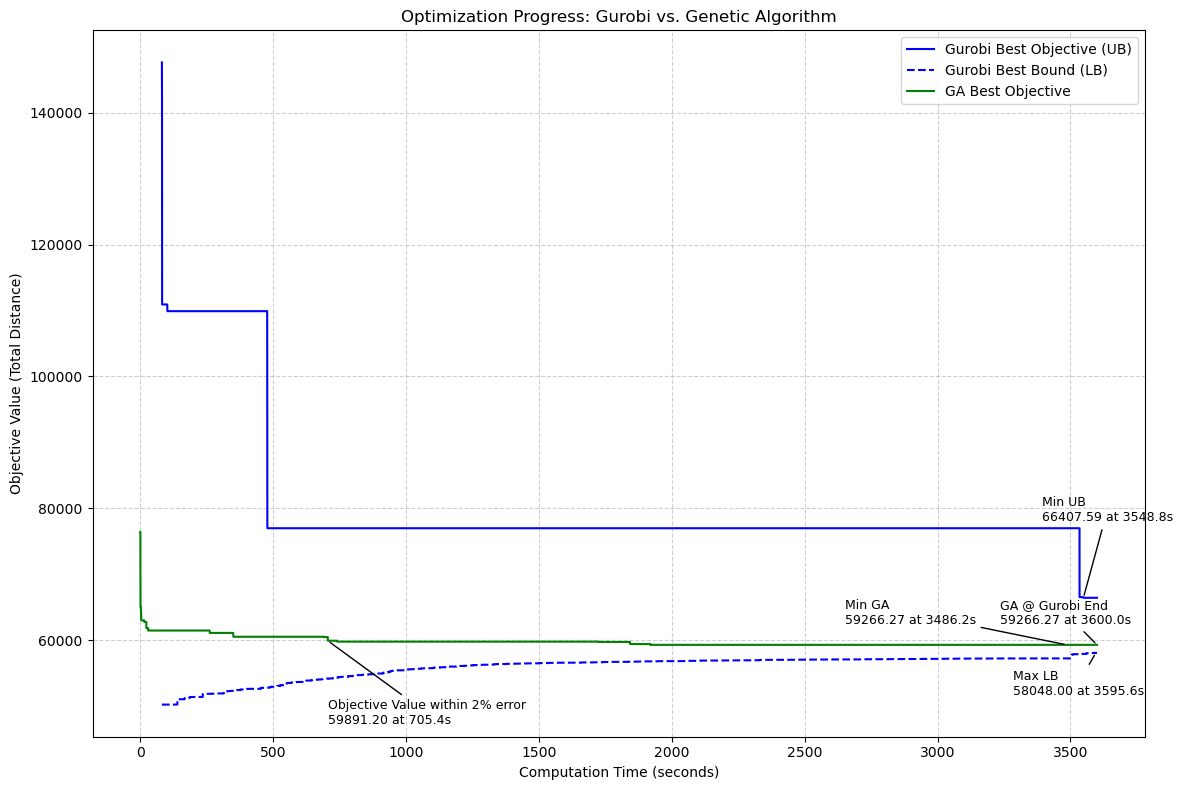

In [24]:
import matplotlib.pyplot as plt

# --- Helper: Find the end of the last significant drop in GA performance ---
def find_end_of_last_significant_drop(objectives, times, threshold=0.01, lookahead=5):
    drop_segments = []
    i = 0
    while i < len(objectives) - 1:
        start_val = objectives[i]
        for j in range(i + 1, len(objectives)):
            curr_val = objectives[j]
            rel_drop = (start_val - curr_val) / start_val if start_val != 0 else 0
            if rel_drop >= threshold:
                end_idx = j
                stable_count = 0
                for k in range(j + 1, len(objectives)):
                    future_val = objectives[k]
                    rel_change = (curr_val - future_val) / curr_val if curr_val != 0 else 0
                    if rel_change < threshold:
                        stable_count += 1
                        if stable_count >= lookahead:
                            end_idx = k - lookahead + 1
                            break
                    else:
                        break
                drop_segments.append((i, end_idx))
                i = end_idx
                break
        i += 1
    if drop_segments:
        _, end_idx = drop_segments[-1]
        return times[end_idx], objectives[end_idx], end_idx
    else:
        min_val = min(objectives)
        min_idx = objectives.index(min_val)
        return times[min_idx], min_val, min_idx

# --- Define Custom Label Offsets ---
label_offsets = {
    'min_ub': (-30, 55),
    'max_lb': (-60, -30),
    'ga_drop': (0, -60),
    'ga_end': (-70, 15),
    'ga_min': (-160, 15),
}

# --- Combined Comparison Plot: Gurobi vs. Genetic Algorithm ---
plt.figure(figsize=(12, 8))

# --- Gurobi Upper & Lower Bounds ---
if 'gurobi_time_points' in locals() and gurobi_time_points and len(gurobi_time_points) > 1:
    plt.plot(gurobi_time_points, gurobi_upper_bounds, label='Gurobi Best Objective (UB)', color='blue', linestyle='-')
    plt.plot(gurobi_time_points, gurobi_lower_bounds, label='Gurobi Best Bound (LB)', color='blue', linestyle='--')

    # Min UB annotation
    min_ub_value = min(gurobi_upper_bounds)
    min_ub_index = gurobi_upper_bounds.index(min_ub_value)
    min_ub_time = gurobi_time_points[min_ub_index]
    plt.annotate(
        f'Min UB\n{min_ub_value:.2f} at {min_ub_time:.1f}s',
        xy=(min_ub_time, min_ub_value),
        xytext=label_offsets['min_ub'],
        textcoords="offset points",
        ha='left',
        fontsize=9,
        color='black',
        arrowprops=dict(arrowstyle='-', color='black', lw=1.0)
    )

    # Max LB annotation
    max_lb_value = max(gurobi_lower_bounds)
    max_lb_index = gurobi_lower_bounds.index(max_lb_value)
    max_lb_time = gurobi_time_points[max_lb_index]
    plt.annotate(
        f'Max LB\n{max_lb_value:.2f} at {max_lb_time:.1f}s',
        xy=(max_lb_time, max_lb_value),
        xytext=label_offsets['max_lb'],
        textcoords="offset points",
        ha='left',
        fontsize=9,
        color='black',
        arrowprops=dict(arrowstyle='-', color='black', lw=1.0)
    )

else:
    print("Gurobi data for bounds over time is not available or insufficient for plotting.")

# --- GA Best Objective ---
if 'ga_time_points' in locals() and ga_time_points and len(ga_time_points) > 1:
    plt.plot(ga_time_points, ga_best_objectives, label='GA Best Objective', color='green', linestyle='-')

    # (1) Annotate the end of the last significant drop
    ga_sig_time, ga_sig_value, ga_sig_index = find_end_of_last_significant_drop(
        ga_best_objectives, ga_time_points, threshold=0.02
    )
    plt.annotate(
        f'Objective Value within 2% error\n{ga_sig_value:.2f} at {ga_sig_time:.1f}s',
        xy=(ga_sig_time, ga_sig_value),
        xytext=label_offsets['ga_drop'],
        textcoords="offset points",
        ha='left',
        fontsize=9,
        color='black',
        arrowprops=dict(arrowstyle='-', color='black', lw=1.0)
    )

    # (2) Annotate the global minimum GA value at its first occurrence
    min_ga_value = min(ga_best_objectives)
    min_ga_index = next(i for i, val in enumerate(ga_best_objectives) if val == min_ga_value)
    min_ga_time = ga_time_points[min_ga_index]
    plt.annotate(
        f'Min GA\n{min_ga_value:.2f} at {min_ga_time:.1f}s',
        xy=(min_ga_time, min_ga_value),
        xytext=label_offsets['ga_min'],
        textcoords="offset points",
        ha='left',
        fontsize=9,
        color='black',
        arrowprops=dict(arrowstyle='-', color='black', lw=1.0)
    )

    # (3) Annotate GA value at Gurobi's final timestamp
    if gurobi_time_points:
        last_gurobi_time = gurobi_time_points[-1]
        closest_ga_index = max(i for i, t in enumerate(ga_time_points) if t <= last_gurobi_time)
        ga_at_gurobi_time = ga_best_objectives[closest_ga_index]
        ga_time_at_gurobi = ga_time_points[closest_ga_index]
        plt.annotate(
            f'GA @ Gurobi End\n{ga_at_gurobi_time:.2f} at {ga_time_at_gurobi:.1f}s',
            xy=(ga_time_at_gurobi, ga_at_gurobi_time),
            xytext=label_offsets['ga_end'],
            textcoords="offset points",
            ha='left',
            fontsize=9,
            color='black',
            arrowprops=dict(arrowstyle='-', color='black', lw=1.0)
        )
else:
    print("GA data for best objective over time is not available or insufficient for plotting.")



# --- Final Plot Formatting ---
plt.title('Optimization Progress: Gurobi vs. Genetic Algorithm')
plt.xlabel('Computation Time (seconds)')
plt.ylabel('Objective Value (Total Distance)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
